Lab ML for Data Science: Part I

In [2]:
import numpy as np
import pandas as pd
#import scipy
#import torch
#import torchvision
from matplotlib import pyplot as plt


# 1 Loading the Data, Preprocessing, Initial Data Analysis

The first step will consist of **downloading the dataset and converting it into numerical tables (e.g. numpy, arrays)**.
In practice, raw data is rarely directly usable as input to machine learning algorithms. In particular, there may be substantial heterogeneity between the different input features. Some features may be physical measurements, monetary measurements, while others may be category indicators or even non-numerical data such as text or images. Hence, a **preliminary filtering** of what is interesting for the analysis we would like to conduct is desirable.

In the context of the UCI wholesale dataset, one may, for example, want to base anomaly and cluster predictions on numerical data (annual spending per category) and drop meta-data such as Channel and the Region indicators or reserve it for an ulterior use. Once such a preliminary step has been taken, we have a standard dataset of size $N × d$ where $N$ is the number of instances (wholesale customers), $d$ is the number of spending categories, and each value in the table can be expressed in monetary unit.

To verify the range and distribution of these values, we can **generate some basic statistical visualizations** of the data. This includes **histograms** showing for each category the distribution of spendings, or **scatter plots** showing the correlation between different product categories. A common observation from such basic statistical analysis is that the distributions are heavy tailed, with many instances having rather small spendings, whereas a few may have spendings one or two orders of magnitude above. 

Any anomaly detection algorithm would systematically highlight those high spenders as anomalous and not make a distinction between spending little and not spending at all.
To address this issue, it can be useful to apply some **nonlinear transformation** to the data, for example, applying the log function to the features so that the distribution becomes compressed for large values and expanded for small values.

$x → log(x + θ)$

Here, we add a positive offset $θ$ in the logarithm so that zero spending $(x = 0)$ does not get mapped to $−∞$. You may experiment with different offsets, such as $θ = 1, θ = 10$ or $θ = 100$. To verify the effect of the transformation, you can **recompute the histograms and scatter plots** in transformed space and check visually whether the transformation had the desired result, e.g. whether the distribution look Gaussian-distributed.

# Loading and Understanding the data

In [3]:
data_pd = pd.read_csv('Wholesale customers data.csv')
data_pd.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
data_pd.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [5]:
data_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


- the dataset has no missing value

In [6]:
data_pd.duplicated().sum()

0

- from such basic statistical analysis is that the distributions are heavy tailed, with many instances having rather small spendings, whereas a few may have spendings one or two orders of magnitude above.

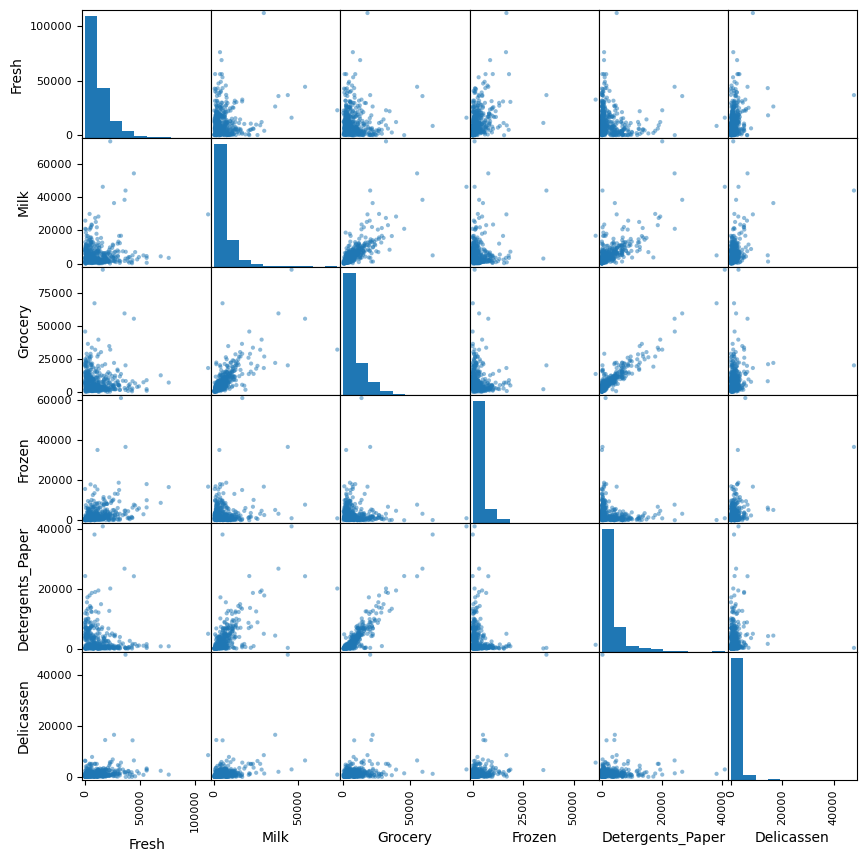

In [7]:
data_scatter = data_pd.iloc[:,2:]  # remove channel and region
pd.plotting.scatter_matrix(data_scatter, figsize=(10, 10))
plt.show()

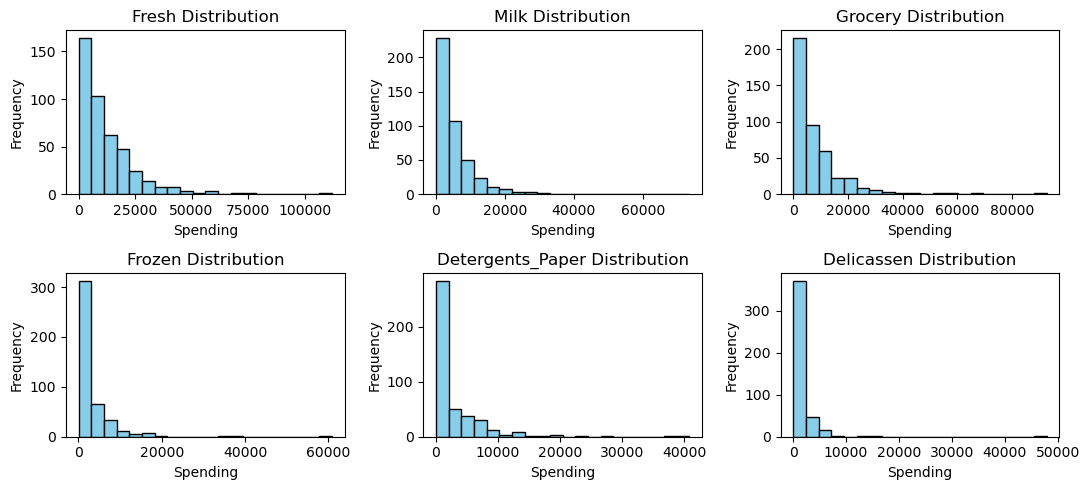

In [8]:
# Plot histograms for each product category
plt.figure(figsize=(11, 5))

for i, column in enumerate(data_scatter.columns):
    plt.subplot(2, 3, i+1)
    plt.hist(data_scatter[column], bins=20, color='skyblue', edgecolor='black')
    plt.title(column + ' Distribution')
    plt.xlabel('Spending')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [9]:
data_scatter.corr()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Fresh,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicassen,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


**Grocery and Detergents Paper are highly correlating. Grocery and Milk are correlating (but weaker with 73%)**

In [10]:
data_pd.groupby(["Region"]).count()

,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Region,,,,,,,
1,77,77,77,77,77,77,77
2,47,47,47,47,47,47,47
3,316,316,316,316,316,316,316


In [11]:
data_pd.groupby(["Channel"]).count()

,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,,,,,,,
1,298,298,298,298,298,298,298
2,142,142,142,142,142,142,142


**class imbalance of region and channel** 

# Preprocessing


### Log transformation to get gaussian distribution

In [12]:
offset = 1e-10
data_log = data_pd.copy()
data_log.iloc[:, 2:] = data_log.iloc[:,2:].apply(lambda x:
                         np.log(x.astype(float) + offset))

C:\Users\merty\AppData\Local\Temp\ipykernel_21092\1317932546.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       9.446913
1       8.861775
2       8.756682
3       9.492884
4      10.026369
         ...    
435    10.299003
436    10.577146
437     9.584040
438     9.238928
439     7.932721
Name: Fresh, Length: 440, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_log.iloc[:, 2:] = data_log.iloc[:,2:].apply(lambda x:
C:\Users\merty\AppData\Local\Temp\ipykernel_21092\1317932546.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      9.175335
1      9.191158
2      9.083416
3      7.086738
4      8.596004
         ...   
435    9.396903
436    7.266129
437    9.647821
438    7.591357
439    7.437206
Name: Milk, Length: 440, dtype: float64' has dtype incompatible with int64, p

In [13]:
data_log.dtypes

Channel               int64
Region                int64
Fresh               float64
Milk                float64
Grocery             float64
Frozen              float64
Detergents_Paper    float64
Delicassen          float64
dtype: object

In [14]:
data_log

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931
1,2,3,8.861775,9.191158,9.166179,7.474205,8.099554,7.482119
2,2,3,8.756682,9.083416,8.946896,7.785305,8.165079,8.967504
3,1,3,9.492884,7.086738,8.347827,8.764678,6.228511,7.488853
4,2,3,10.026369,8.596004,8.881558,8.272571,7.482682,8.553525
...,...,...,...,...,...,...,...,...
435,1,3,10.299003,9.396903,9.682030,9.483036,5.204007,7.698029
436,1,3,10.577146,7.266129,6.638568,8.414052,4.532599,7.760467
437,2,3,9.584040,9.647821,10.317020,6.079933,9.605149,7.532088
438,1,3,9.238928,7.591357,7.710653,6.945051,5.123964,7.661527


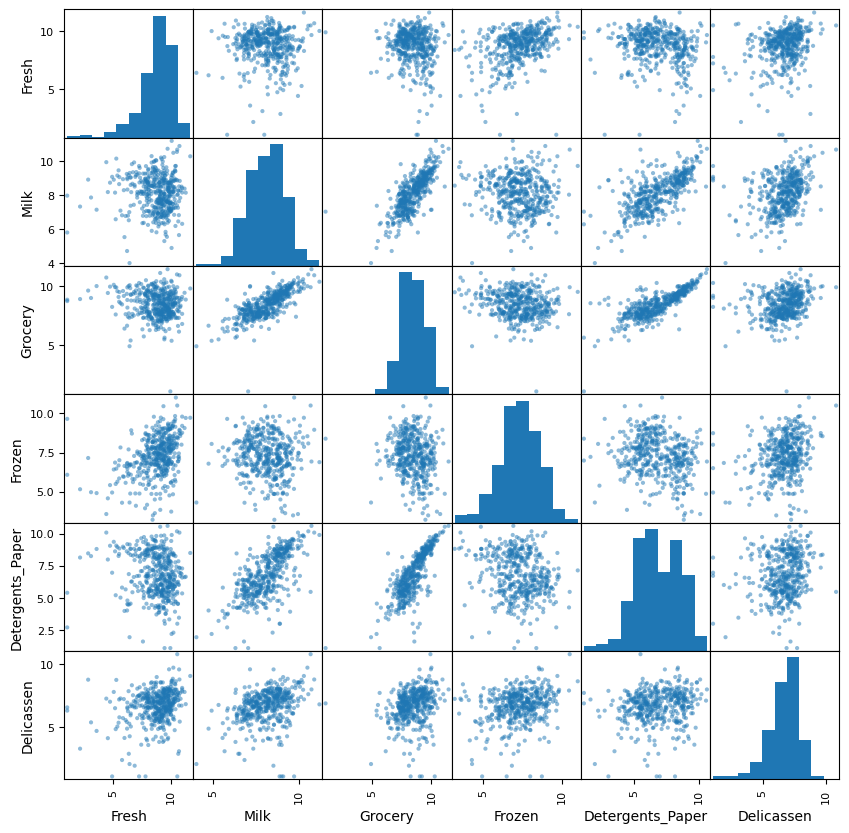

In [15]:
data_log_scatter = data_log.iloc[:,2:]  # remove channel and region
pd.plotting.scatter_matrix(data_log_scatter, figsize=(10, 10))
plt.show()

**Now the the features are gaussian distributed and we can continue with anomaly detection**

In [16]:
data_log_scatter.corr()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Fresh,1.000000,-0.019834,-0.132713,0.383996,-0.155871,0.255186
Milk,-0.019834,1.000000,0.758851,-0.055316,0.677942,0.337833
Grocery,-0.132713,0.758851,1.000000,-0.164524,0.796398,0.235728
Frozen,0.383996,-0.055316,-0.164524,1.000000,-0.211576,0.254718
Detergents_Paper,-0.155871,0.677942,0.796398,-0.211576,1.000000,0.166735
Delicassen,0.255186,0.337833,0.235728,0.254718,0.166735,1.000000


In [17]:
data_pd.iloc[:,2].value_counts()


Fresh
9670     2
3        2
18044    2
8040     2
514      2
        ..
18827    1
10405    1
37036    1
30379    1
2787     1
Name: count, Length: 433, dtype: int64

# Anomaly detection



In [18]:
data_log

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931
1,2,3,8.861775,9.191158,9.166179,7.474205,8.099554,7.482119
2,2,3,8.756682,9.083416,8.946896,7.785305,8.165079,8.967504
3,1,3,9.492884,7.086738,8.347827,8.764678,6.228511,7.488853
4,2,3,10.026369,8.596004,8.881558,8.272571,7.482682,8.553525
...,...,...,...,...,...,...,...,...
435,1,3,10.299003,9.396903,9.682030,9.483036,5.204007,7.698029
436,1,3,10.577146,7.266129,6.638568,8.414052,4.532599,7.760467
437,2,3,9.584040,9.647821,10.317020,6.079933,9.605149,7.532088
438,1,3,9.238928,7.591357,7.710653,6.945051,5.123964,7.661527


In [19]:
feature_list = ["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]

In [20]:
data_log_anomaly = data_log.copy()

In [21]:
data_log_anomaly.iloc[0,2:], data_log_anomaly.iloc[1,2:]

(Fresh               9.446913
 Milk                9.175335
 Grocery             8.930759
 Frozen              5.365976
 Detergents_Paper    7.891331
 Delicassen          7.198931
 Name: 0, dtype: float64,
 Fresh               8.861775
 Milk                9.191158
 Grocery             9.166179
 Frozen              7.474205
 Detergents_Paper    8.099554
 Delicassen          7.482119
 Name: 1, dtype: float64)

In [22]:
data_log_anomaly.iloc[0,2:] - data_log_anomaly.iloc[1,2:]

Fresh               0.585138
Milk               -0.015823
Grocery            -0.235421
Frozen             -2.108229
Detergents_Paper   -0.208224
Delicassen         -0.283188
dtype: float64

In [23]:
data_log_anomaly.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,8.730544,8.121047,8.441169,7.301396,6.785972,6.665133
std,0.468052,0.774272,1.480071,1.081365,1.116172,1.284540,1.721020,1.310832
min,1.000000,1.000000,1.098612,4.007333,1.098612,3.218876,1.098612,1.098612
25%,1.000000,2.000000,8.048059,7.334981,7.674616,6.609678,5.548101,6.011875
50%,1.000000,3.000000,9.048286,8.196159,8.467057,7.330388,6.705018,6.872645
75%,2.000000,3.000000,9.737064,8.880480,9.273854,8.175896,8.274341,7.506728
max,2.000000,3.000000,11.627601,11.205013,11.437986,11.016479,10.617099,10.777768


In [24]:
data_log_anomaly["outlier_score"] = None 

In [25]:
data_log_anomaly

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,outlier_score
0,2,3,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931,None
1,2,3,8.861775,9.191158,9.166179,7.474205,8.099554,7.482119,None
2,2,3,8.756682,9.083416,8.946896,7.785305,8.165079,8.967504,None
3,1,3,9.492884,7.086738,8.347827,8.764678,6.228511,7.488853,None
4,2,3,10.026369,8.596004,8.881558,8.272571,7.482682,8.553525,None
...,...,...,...,...,...,...,...,...,...
435,1,3,10.299003,9.396903,9.682030,9.483036,5.204007,7.698029,None
436,1,3,10.577146,7.266129,6.638568,8.414052,4.532599,7.760467,None
437,2,3,9.584040,9.647821,10.317020,6.079933,9.605149,7.532088,None
438,1,3,9.238928,7.591357,7.710653,6.945051,5.123964,7.661527,None


In [26]:
np.sum([[12,3,4], [5,6,7]])

37

In [27]:
a = np.array([[1,2],[3,4]])
np.sum(a[0])

3

In [28]:
data_log_anomaly.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,8.730544,8.121047,8.441169,7.301396,6.785972,6.665133
std,0.468052,0.774272,1.480071,1.081365,1.116172,1.284540,1.721020,1.310832
min,1.000000,1.000000,1.098612,4.007333,1.098612,3.218876,1.098612,1.098612
25%,1.000000,2.000000,8.048059,7.334981,7.674616,6.609678,5.548101,6.011875
50%,1.000000,3.000000,9.048286,8.196159,8.467057,7.330388,6.705018,6.872645
75%,2.000000,3.000000,9.737064,8.880480,9.273854,8.175896,8.274341,7.506728
max,2.000000,3.000000,11.627601,11.205013,11.437986,11.016479,10.617099,10.777768


In [45]:
testdata = data_log_anomaly.iloc[:10,:]
testdata

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,outlier_score
0,2,3,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931,100000000000000000000.0
1,2,3,8.861775,9.191158,9.166179,7.474205,8.099554,7.482119,100000000000000000000.0
2,2,3,8.756682,9.083416,8.946896,7.785305,8.165079,8.967504,11.783475
3,1,3,9.492884,7.086738,8.347827,8.764678,6.228511,7.488853,5.796001
4,2,3,10.026369,8.596004,8.881558,8.272571,7.482682,8.553525,100000000000000000000.0
5,2,3,9.149847,9.019059,8.542081,6.501290,7.492760,7.280008,100000000000000000000.0
6,2,3,9.403107,8.070594,8.850088,6.173786,8.051978,6.300786,4.459717
7,2,3,8.933137,8.508354,9.151227,7.419980,8.108021,7.850104,100000000000000000000.0
8,1,3,8.693329,8.201934,8.731013,6.052089,7.447751,6.620073,6.690312
9,2,3,8.700514,9.314070,9.845911,7.055313,8.912608,7.648740,None


In [50]:
def calculate_distances(df):
    epsilon = 1e-100
    highNumber = 1e20 # to avoid that distance between self data point is selected when searching the minimum and 0 would be the minimum so use high number
    distances_vectors = []
    distances_scalars = []
    outlier_score_index = df.columns.get_loc("outlier_score")

    for j in range(len(df)-1):
        for k in range(len(df)-1):
            if j ==k:
                distances_vectors.append([])
                distances_scalars.append(highNumber)
            else:
                distances_vectors.append((df.iloc[j,2:8] - df.iloc[j+1,2:8]) **2)  #append x_j - x_k vectors
                distances_scalars.append(np.sum(distances_vectors[k]))  # z_jk := add all distances of the 6 features 

        #print(distances_scalars)
        df.iloc[j, outlier_score_index] =  np.min(distances_scalars)

        distances_vectors = []
        distances_scalars = []

calculate_distances(testdata)
testdata

[1e+20, 4.966240740162394, 4.966240740162394, 4.966240740162394, 4.966240740162394, 4.966240740162394, 4.966240740162394, 4.966240740162394, 4.966240740162394]
[2.3781846269747207, 1e+20, 2.3781846269747207, 2.3781846269747207, 2.3781846269747207, 2.3781846269747207, 2.3781846269747207, 2.3781846269747207, 2.3781846269747207]
[11.783475184521187, 11.783475184521187, 1e+20, 11.783475184521187, 11.783475184521187, 11.783475184521187, 11.783475184521187, 11.783475184521187, 11.783475184521187]
[5.796000766868456, 5.796000766868456, 5.796000766868456, 1e+20, 5.796000766868456, 5.796000766868456, 5.796000766868456, 5.796000766868456, 5.796000766868456]
[5.821893295159936, 5.821893295159936, 5.821893295159936, 5.821893295159936, 1e+20, 5.821893295159936, 5.821893295159936, 5.821893295159936, 5.821893295159936]
[2.437454923350314, 2.437454923350314, 2.437454923350314, 2.437454923350314, 2.437454923350314, 1e+20, 2.437454923350314, 2.437454923350314, 2.437454923350314]
[4.4597171992443165, 4.4

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,outlier_score
0,2,3,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931,4.966241
1,2,3,8.861775,9.191158,9.166179,7.474205,8.099554,7.482119,2.378185
2,2,3,8.756682,9.083416,8.946896,7.785305,8.165079,8.967504,11.783475
3,1,3,9.492884,7.086738,8.347827,8.764678,6.228511,7.488853,5.796001
4,2,3,10.026369,8.596004,8.881558,8.272571,7.482682,8.553525,5.821893
5,2,3,9.149847,9.019059,8.542081,6.501290,7.492760,7.280008,2.437455
6,2,3,9.403107,8.070594,8.850088,6.173786,8.051978,6.300786,4.459717
7,2,3,8.933137,8.508354,9.151227,7.419980,8.108021,7.850104,4.148037
8,1,3,8.693329,8.201934,8.731013,6.052089,7.447751,6.620073,6.690312
9,2,3,8.700514,9.314070,9.845911,7.055313,8.912608,7.648740,None
